# Streamlined Extraction of Nucleic Acids and Metabolites from Low- and High-Biomass Samples Using Isopropanol and Matrix Tubes

## LC-MS/MS UpSet plots

## Set up notebook environment
### Note: A folder called 'assets' is also needed, which should contain the assets provided in the same repo as this code.


In [1]:
import os
import biom
import warnings
import numpy as np
import pandas as pd
import qiime2 as q2
from biom import Table
from assets.util import add_taxsplit
from skbio import OrdinationResults
from qiime2.plugins.emperor.actions import biplot

# Plotting
import matplotlib
import seaborn as sns
import matplotlib.pyplot as plt
import pyupset as pyu
from upsetplot import UpSet
from upsetplot import generate_counts, plot
from upsetplot import from_memberships
from matplotlib_venn import venn2
from matplotlib_venn import (venn3, venn3_circles,
                             venn2_circles)

warnings.filterwarnings('ignore')
warnings.filterwarnings("ignore", category=DeprecationWarning)
plt.style.use('ggplot')
plt.style.use('tableau-colorblind10')
paper_rc = {'lines.markersize': 5}                  
sns.set_context("paper", rc = paper_rc)   
plt.rcParams['xtick.labelsize'] = 18
plt.rcParams['ytick.labelsize'] = 18
plt.rcParams['axes.linewidth'] = 2
plt.rcParams["font.weight"] = "bold"
plt.rcParams["axes.labelweight"] = "bold"
plt.rcParams['xtick.major.pad'] = '.1'

%matplotlib inline


In [2]:
def format_uplot(df):
    df_binary = (df > 0.0).rename(columns=lambda x: x + '>0')
    df = pd.concat([df, df_binary], axis=1)
    index_ = df.index
    df = df.set_index(list(df_binary.columns))
    df['taxa'] = index_
    return df


# Create UpSet plots

class


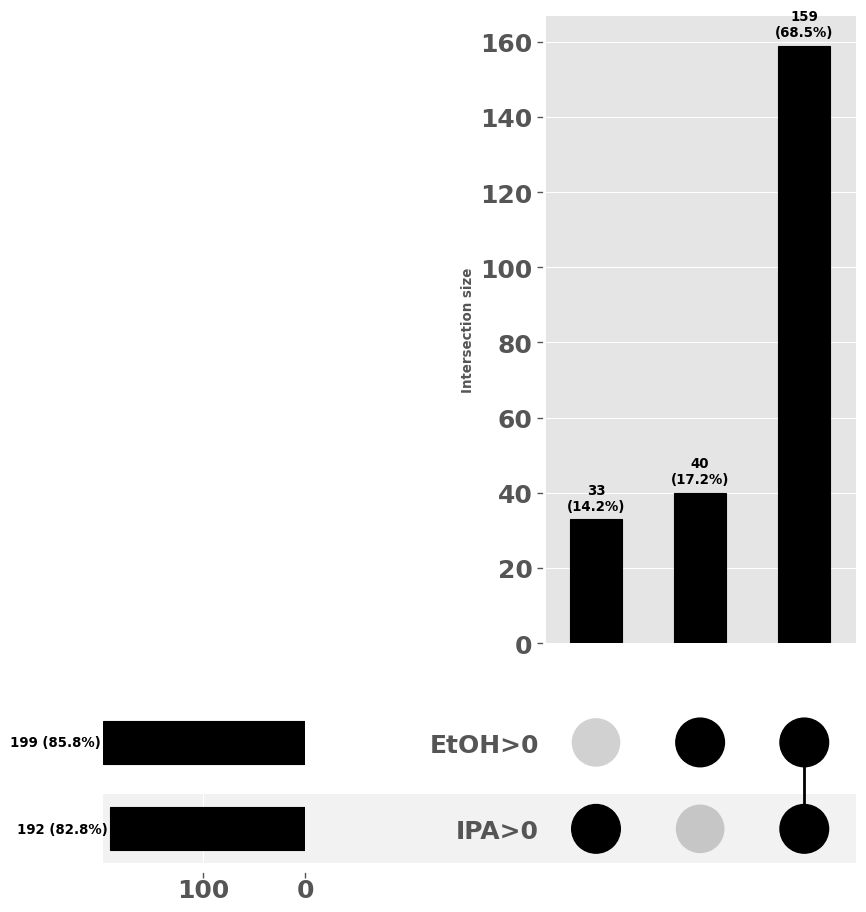

order


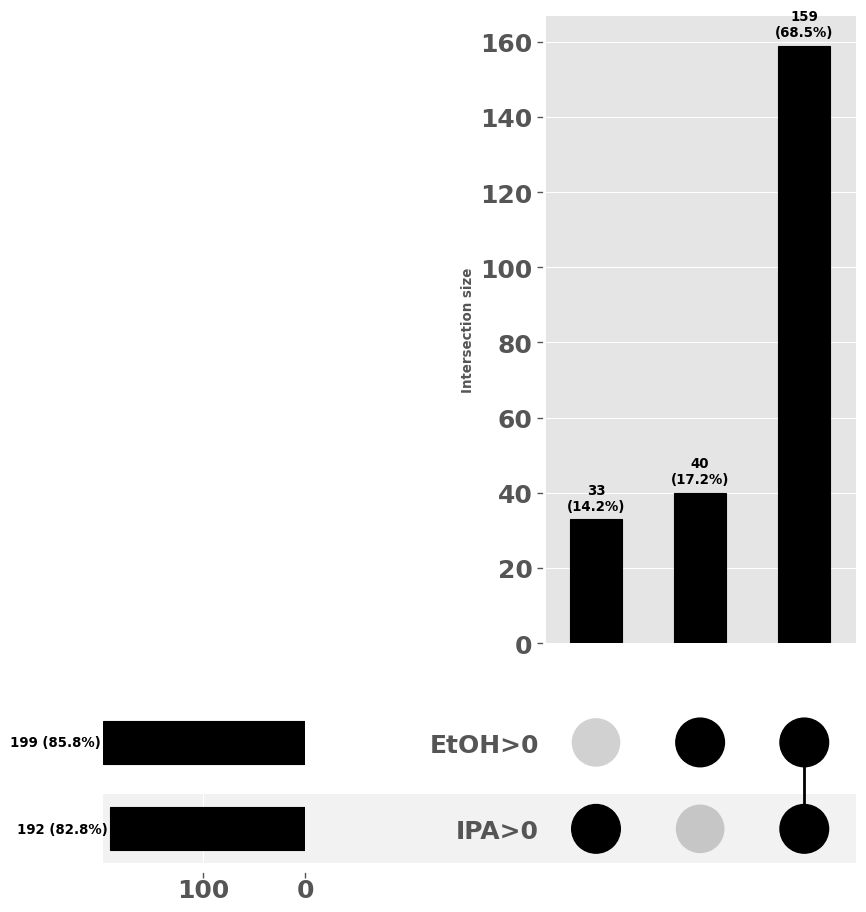

family


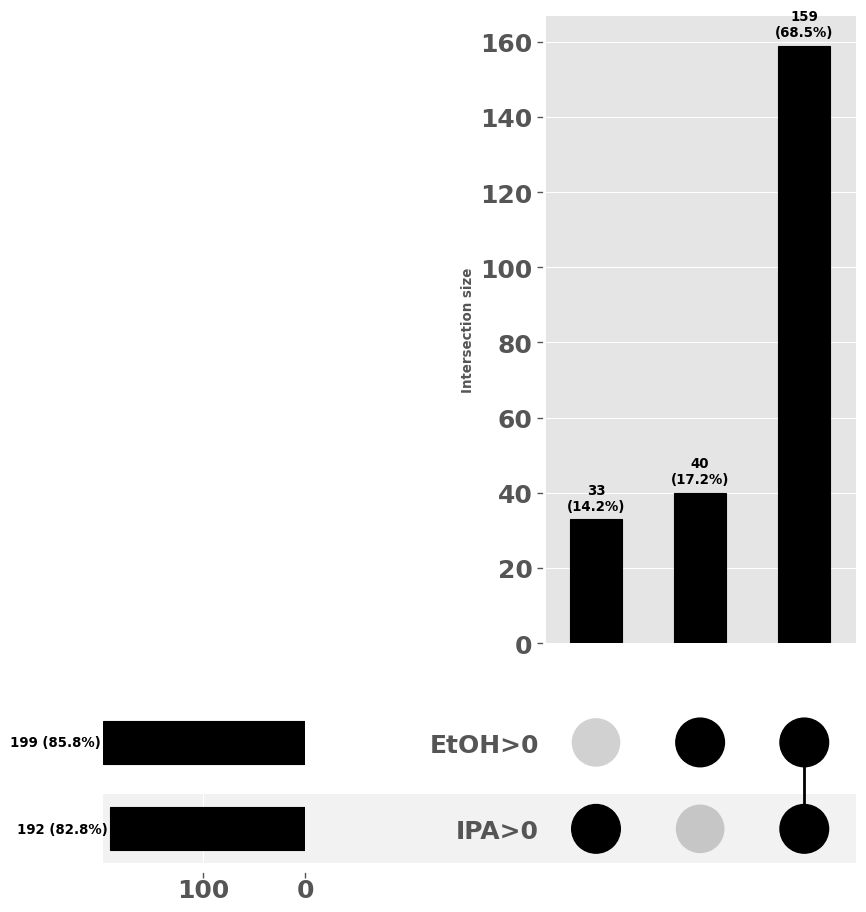

genus


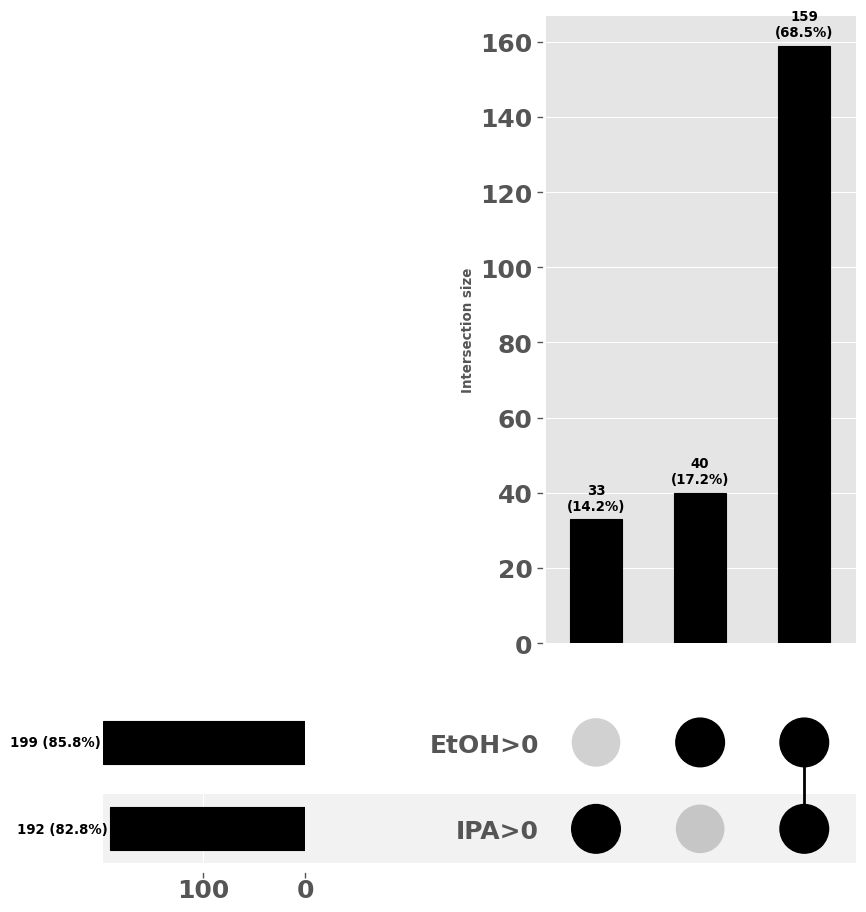

species


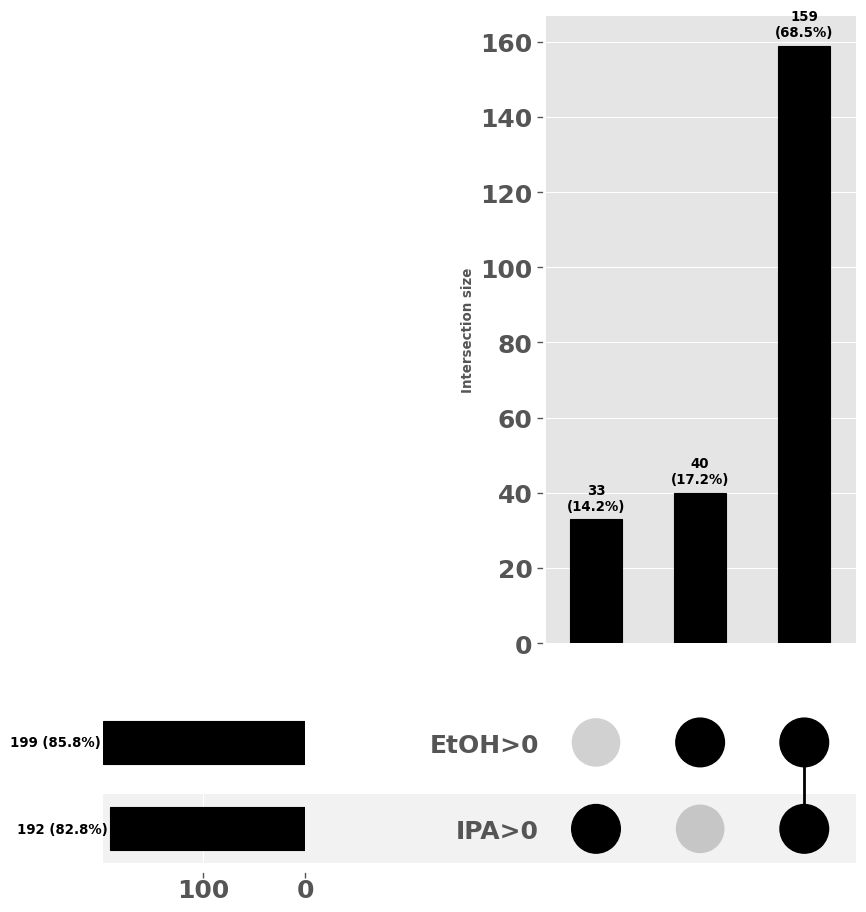

class


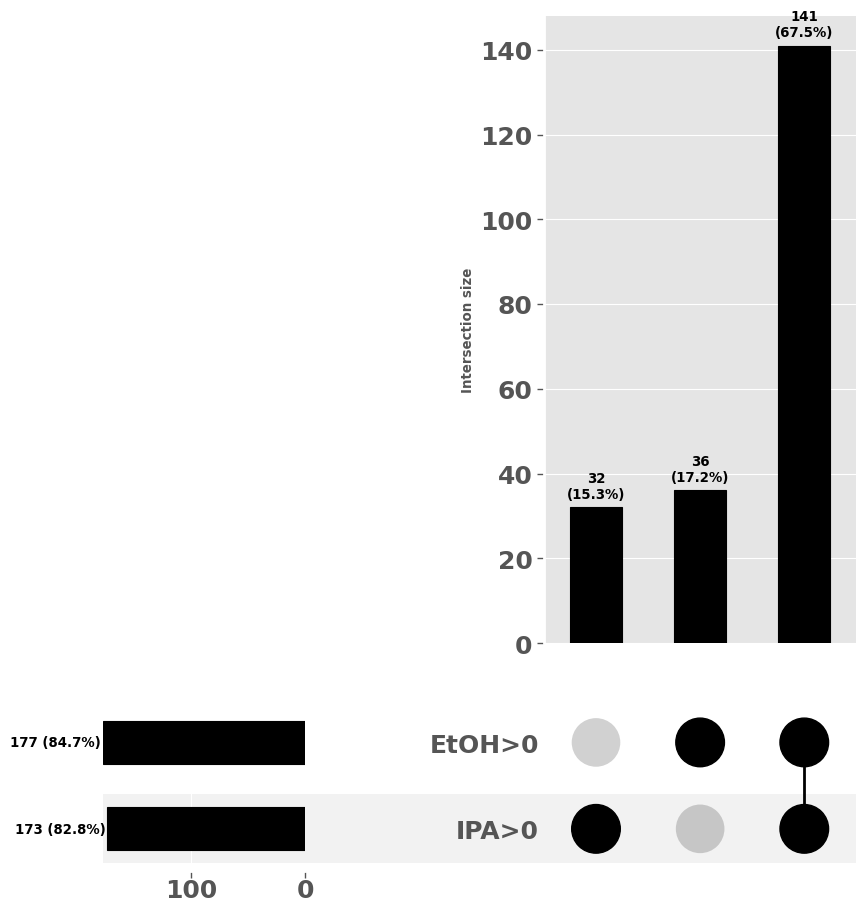

order


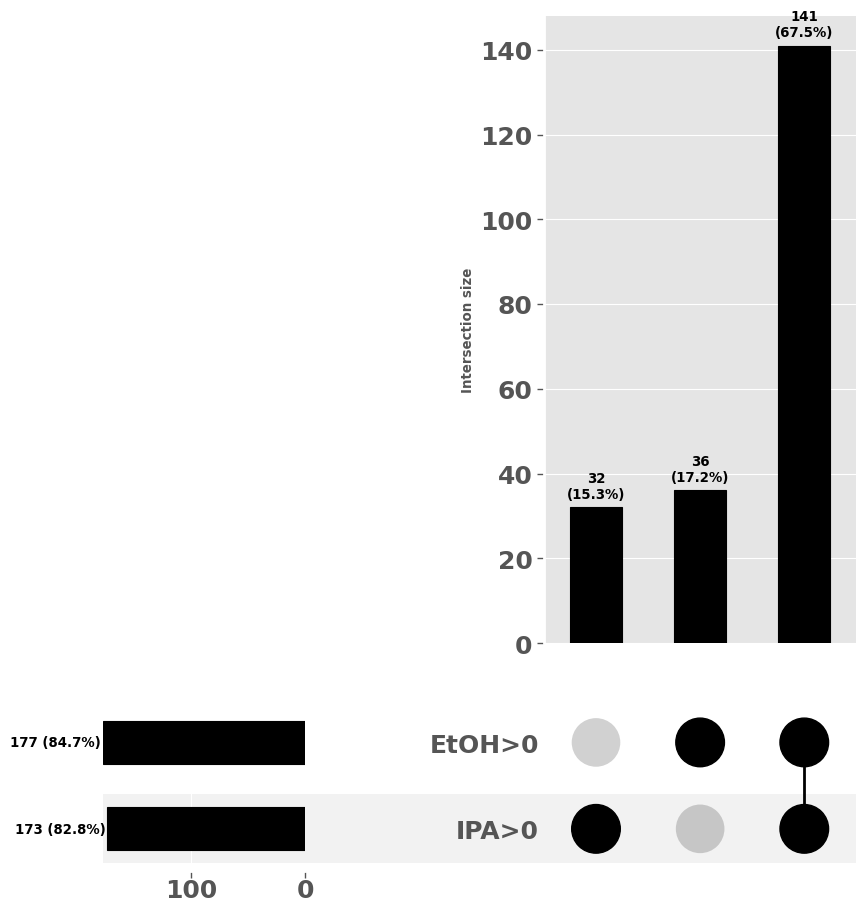

family


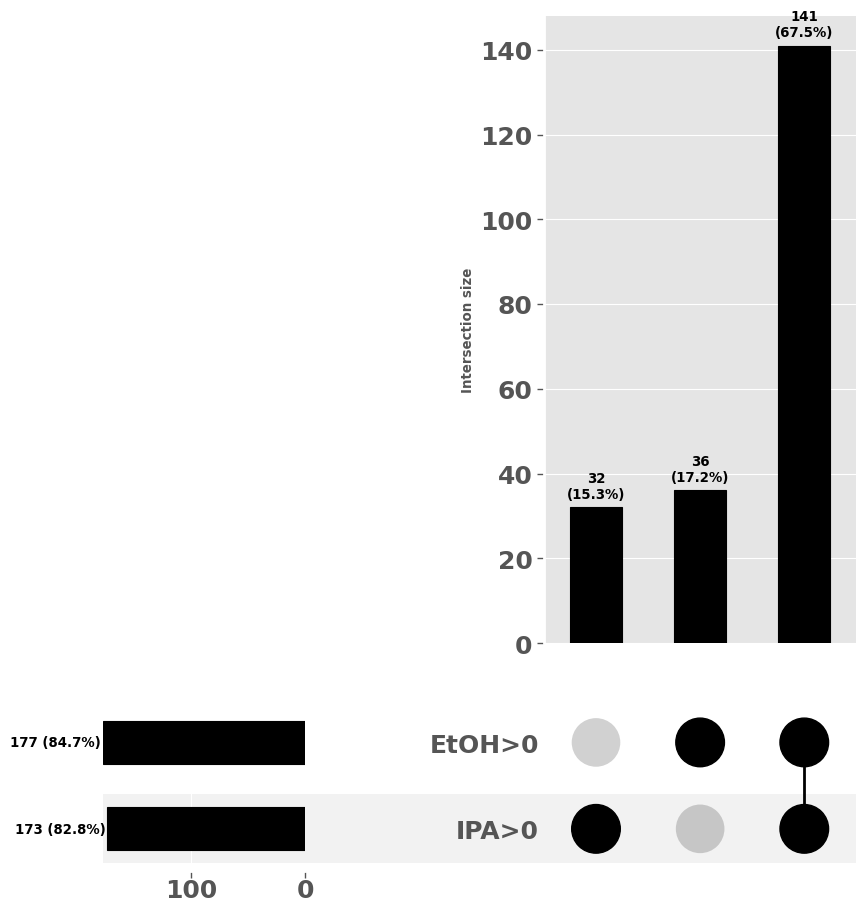

genus


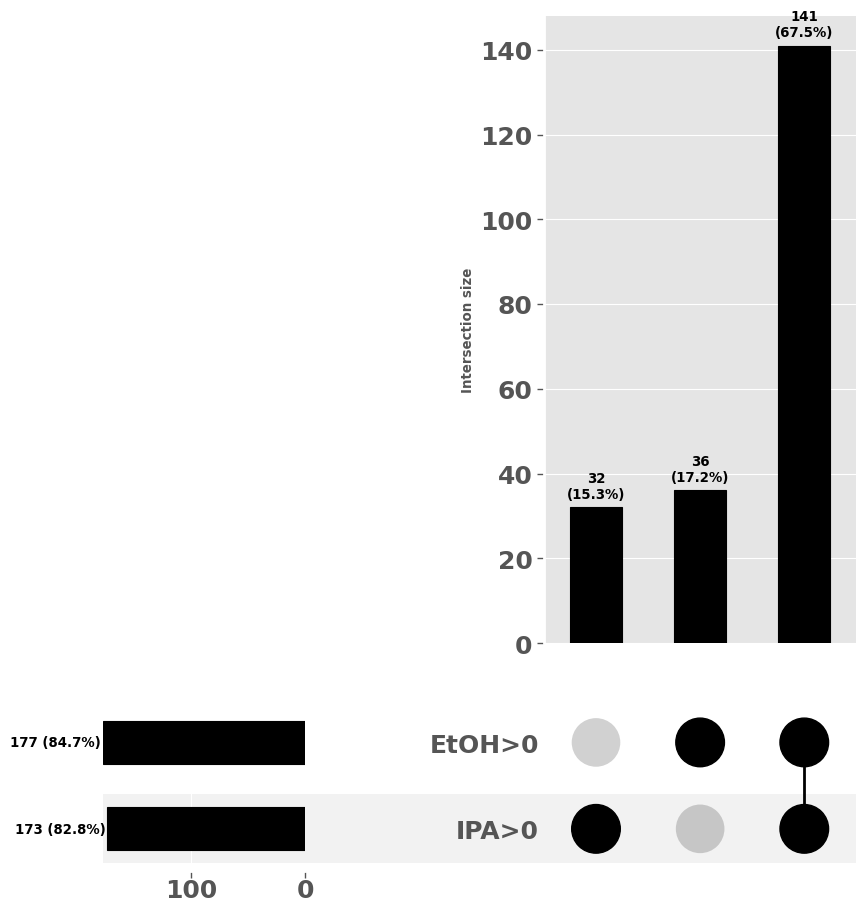

species


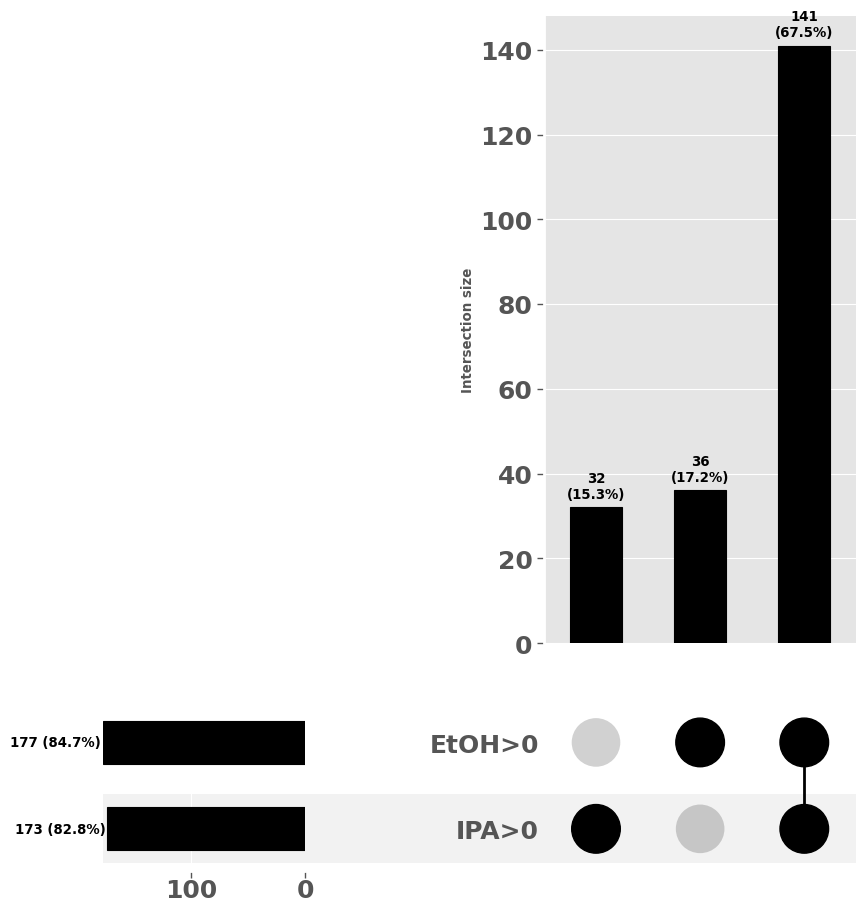

class


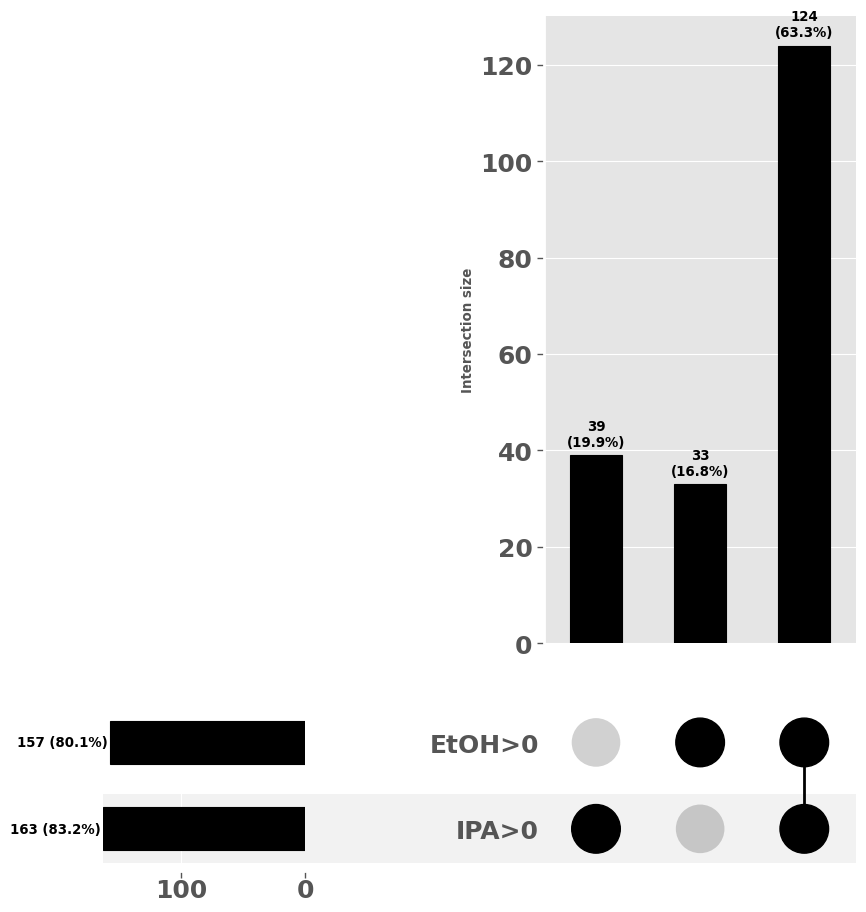

order


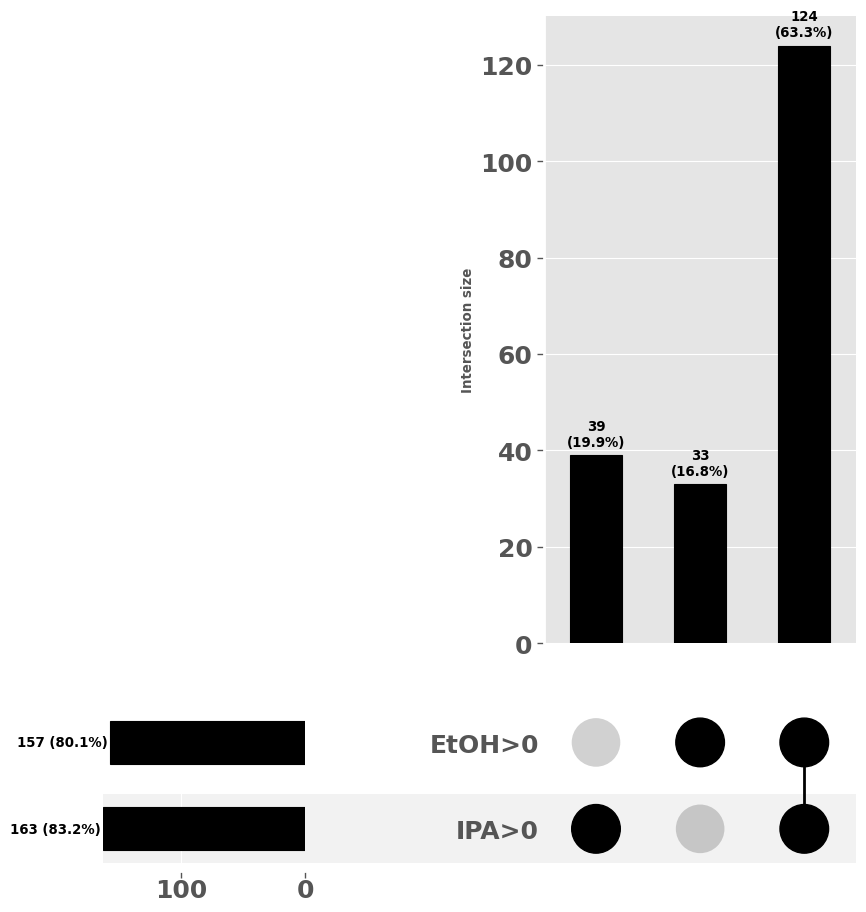

family


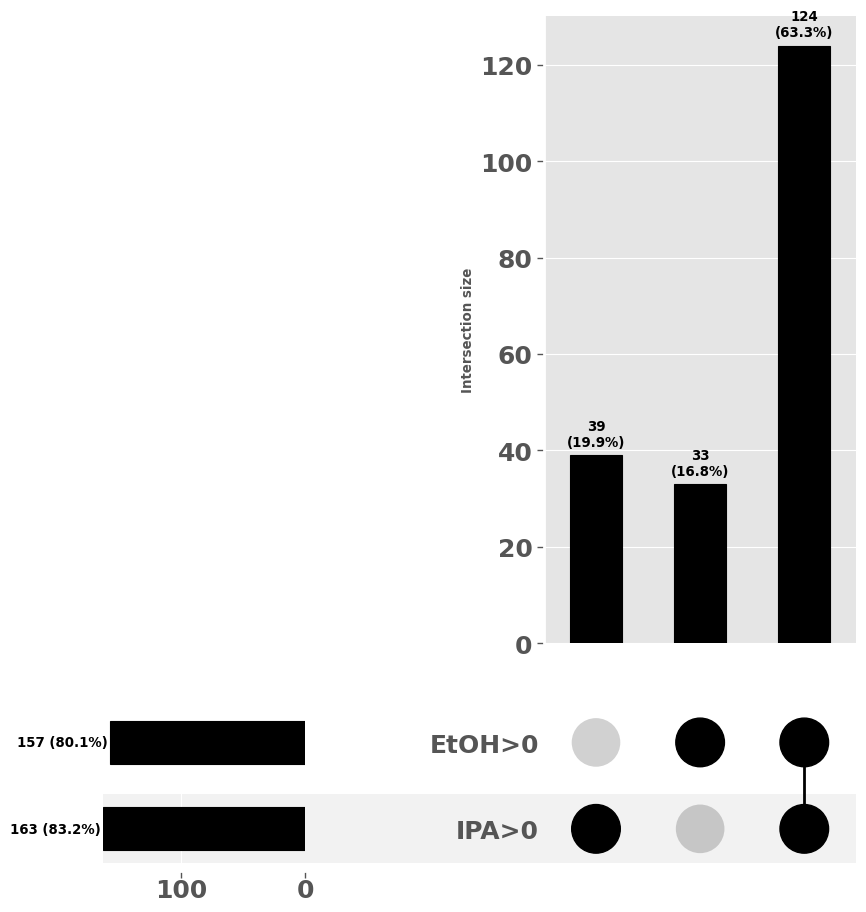

genus


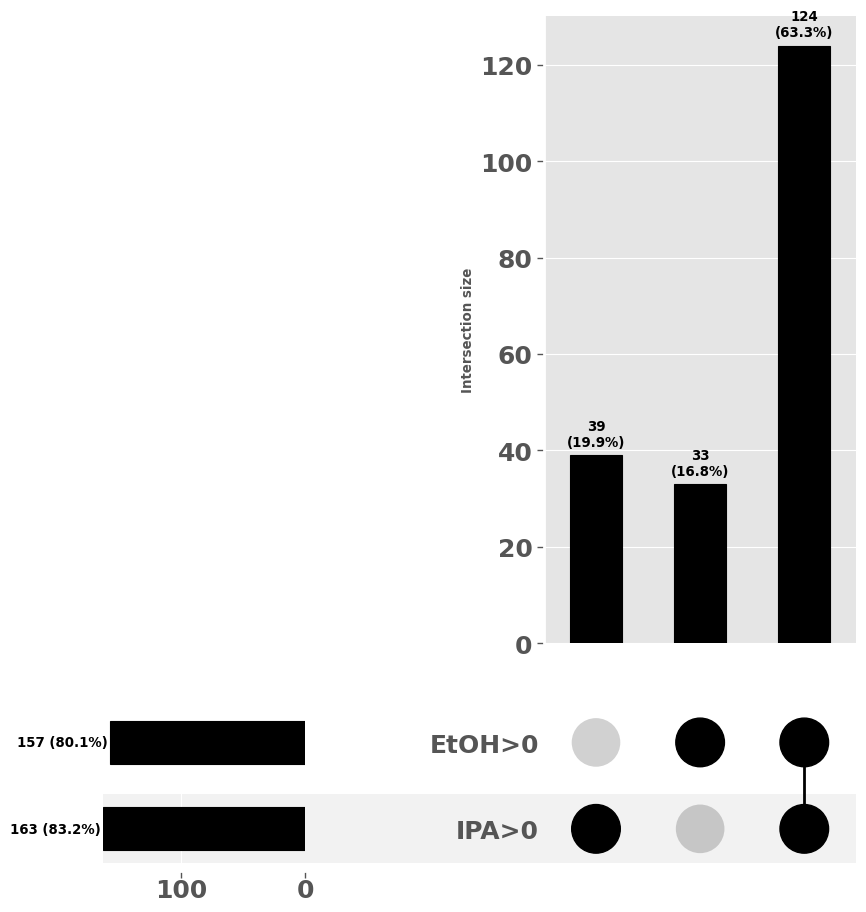

species


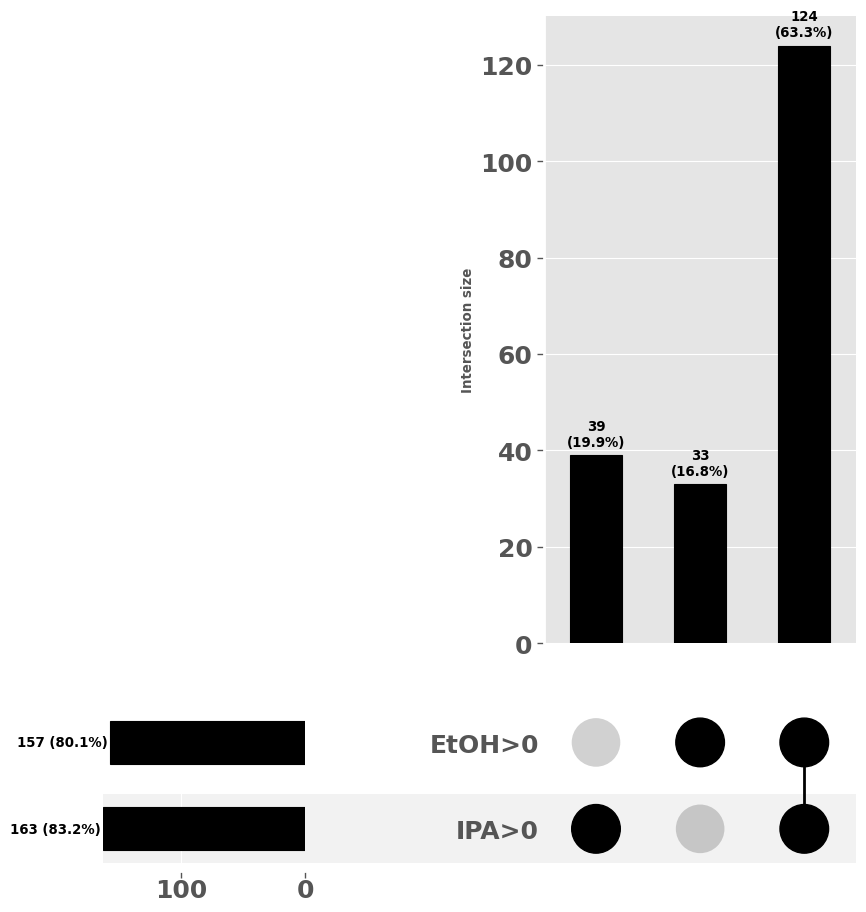

class


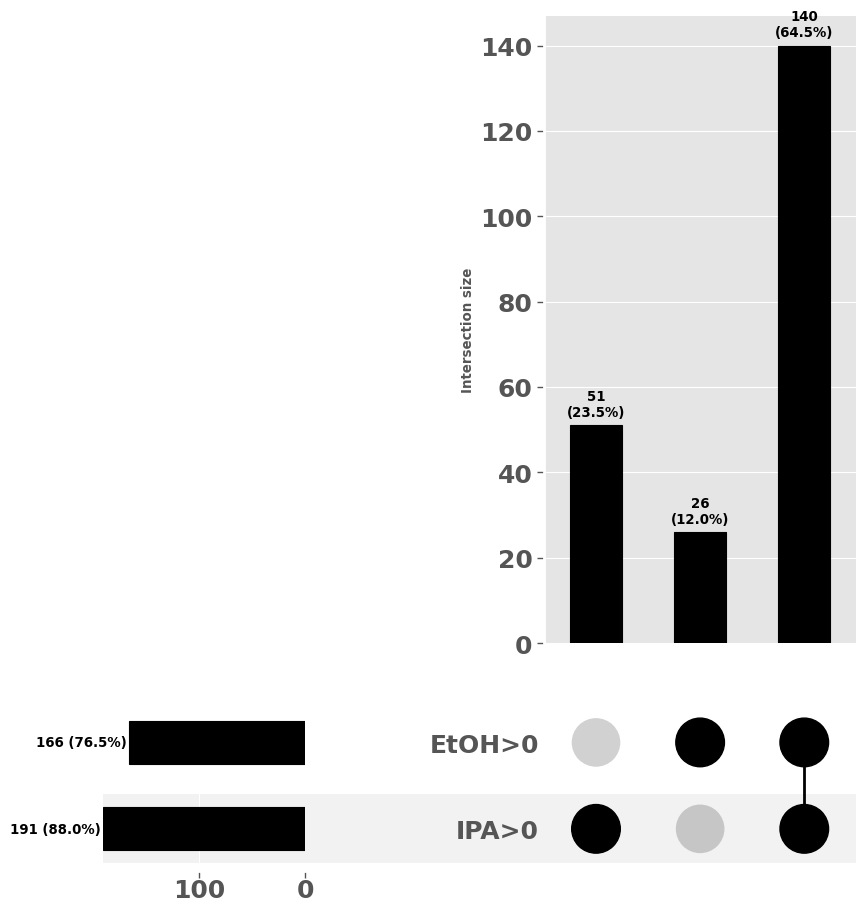

order


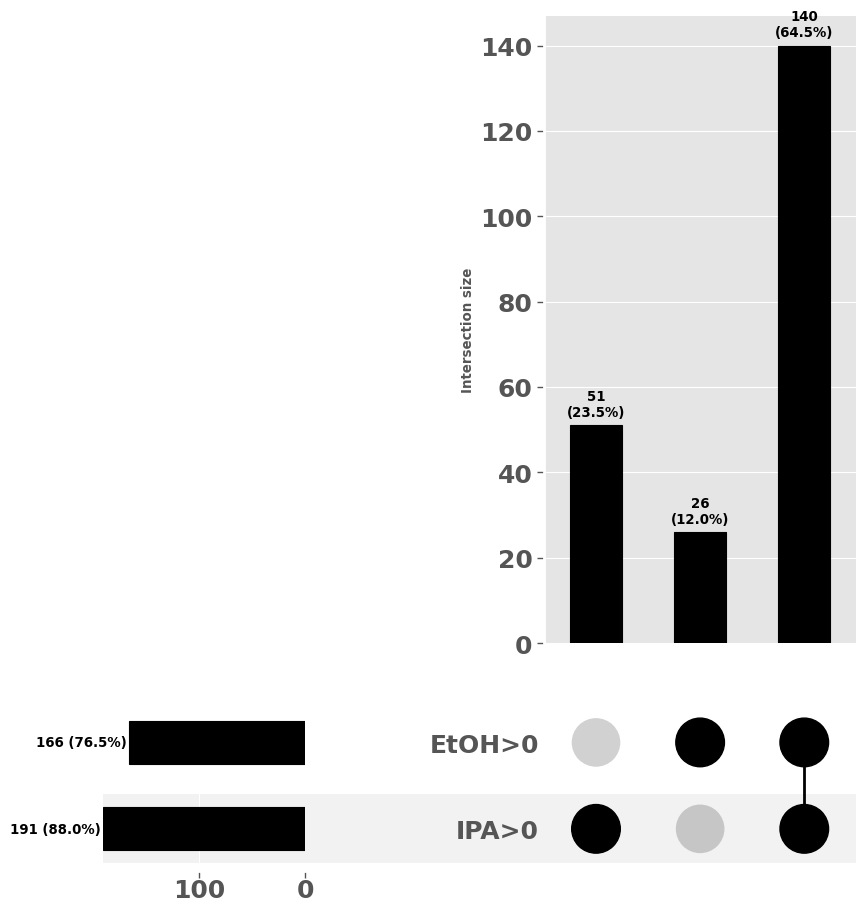

family


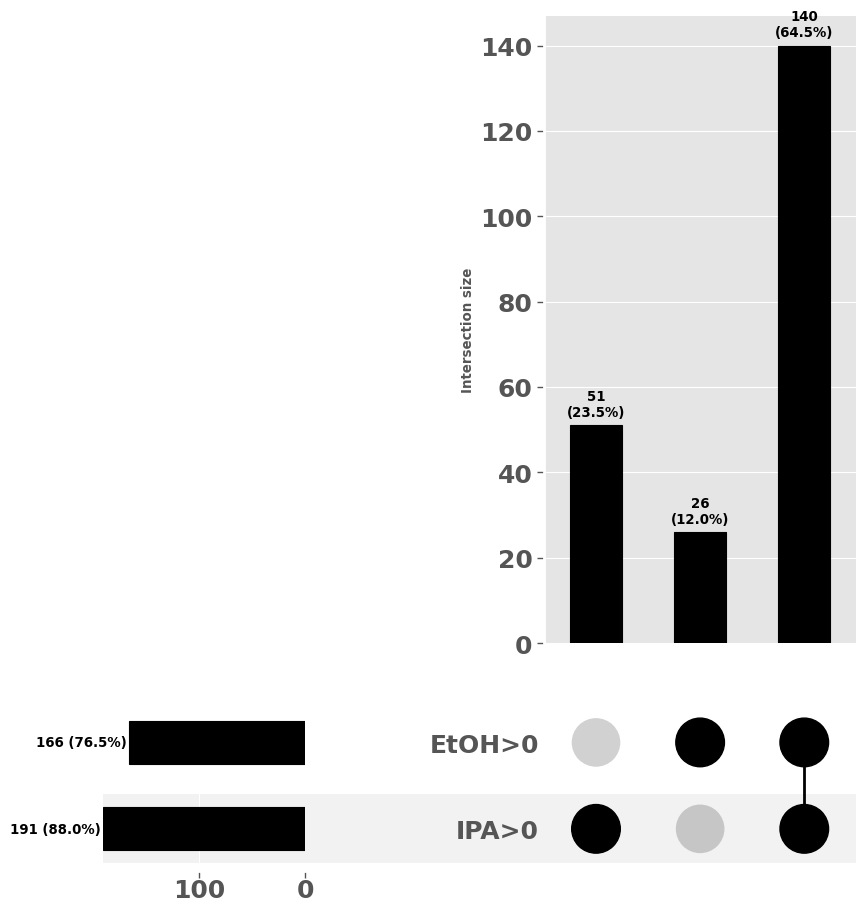

genus


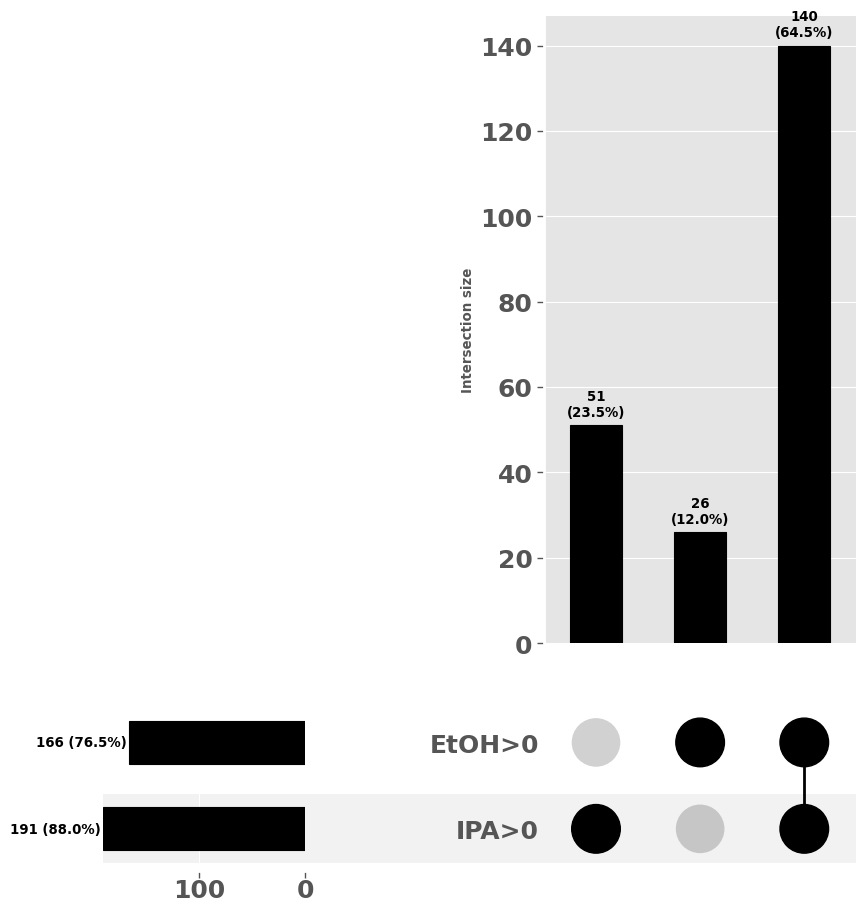

species


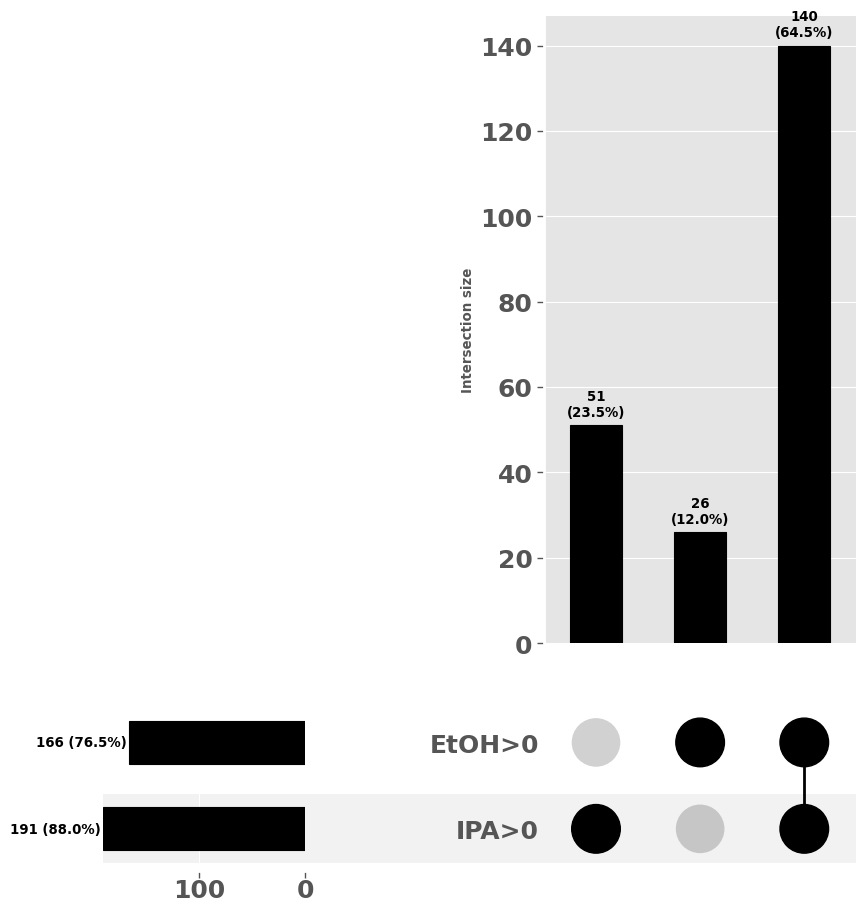

class


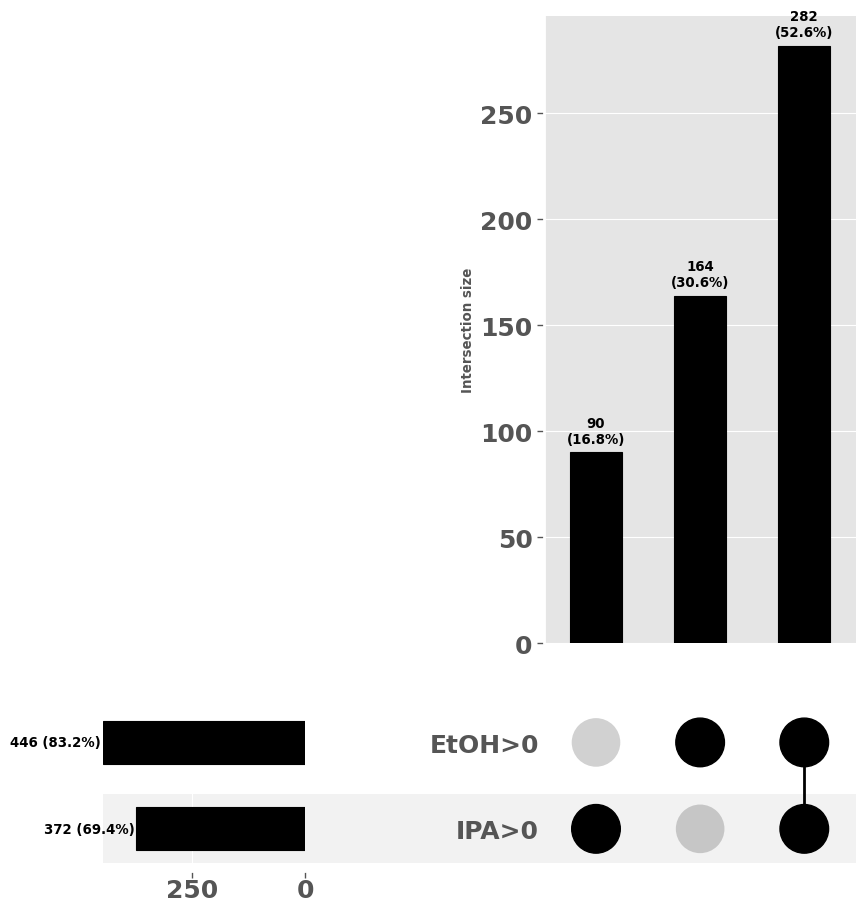

order


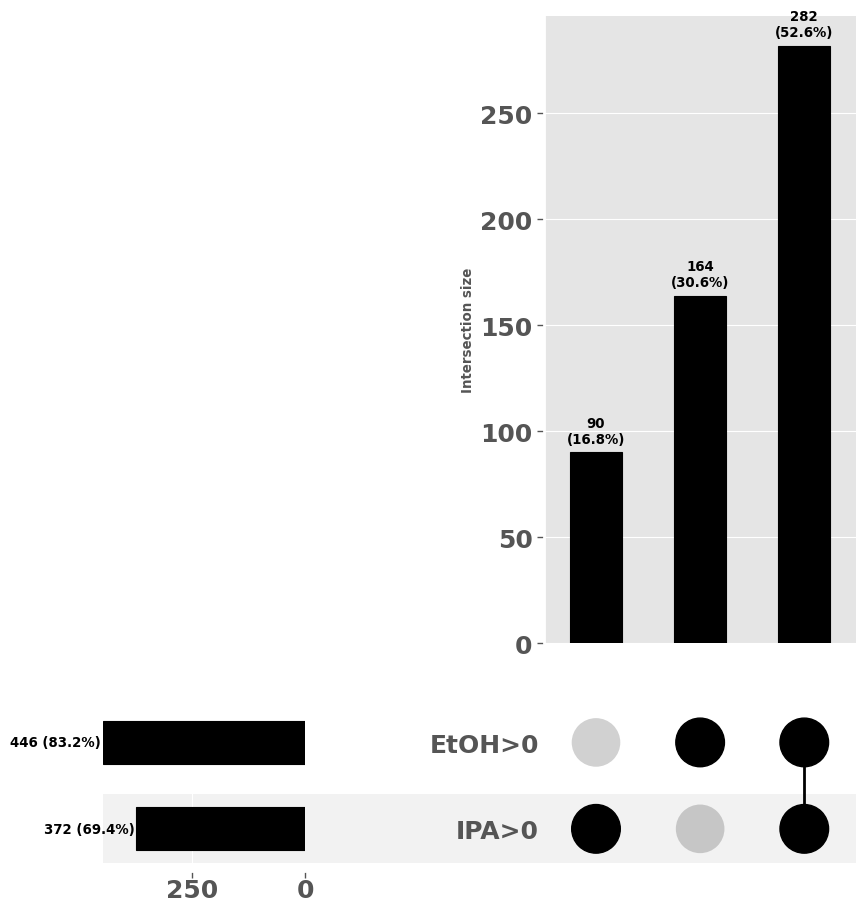

family


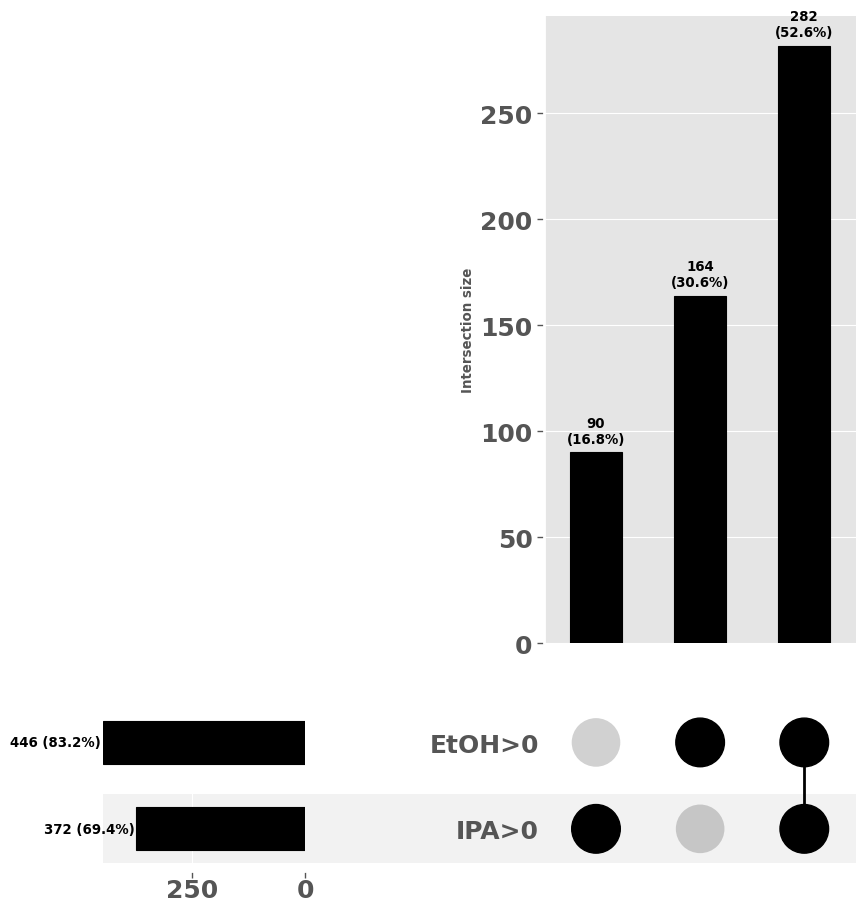

genus


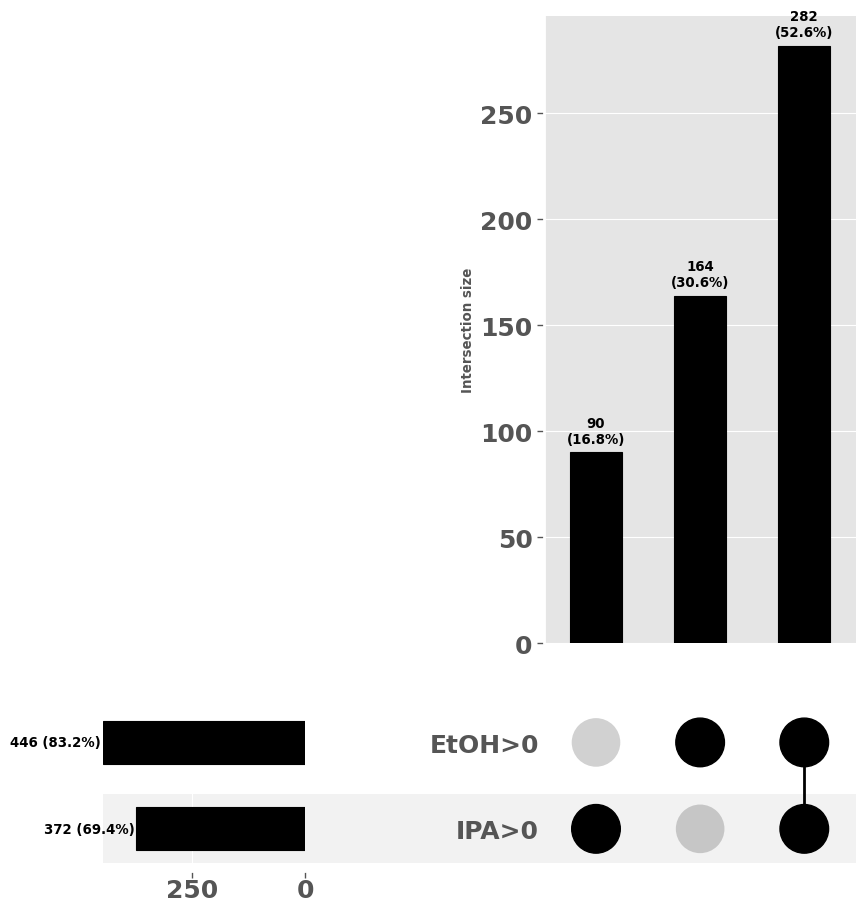

species


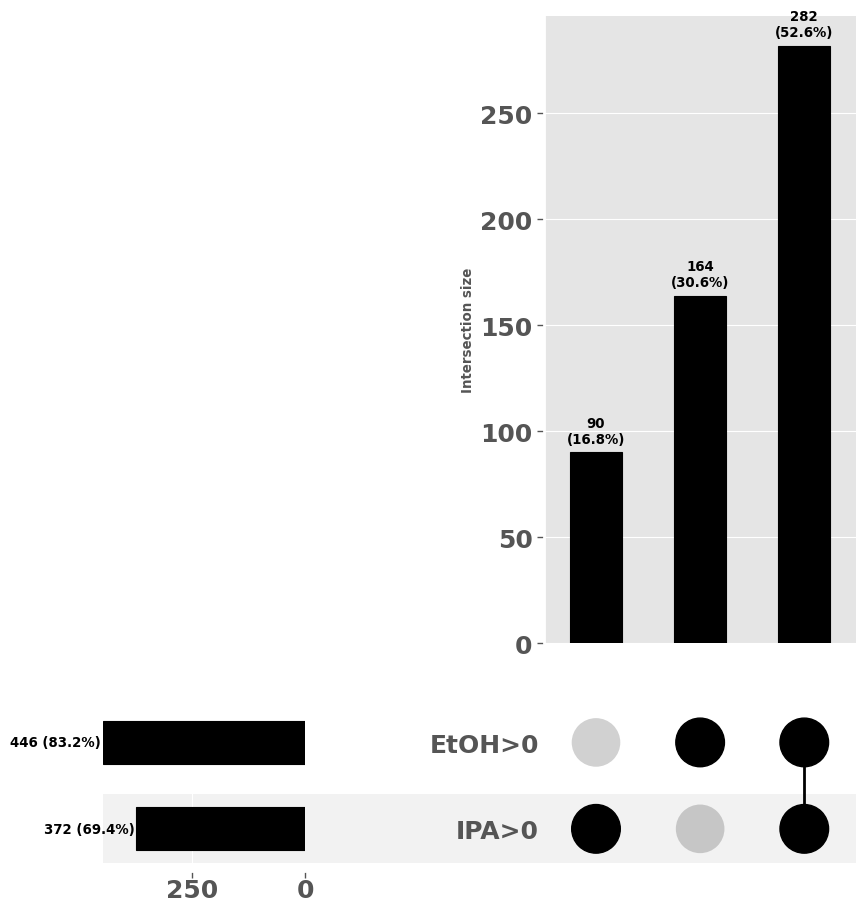

class


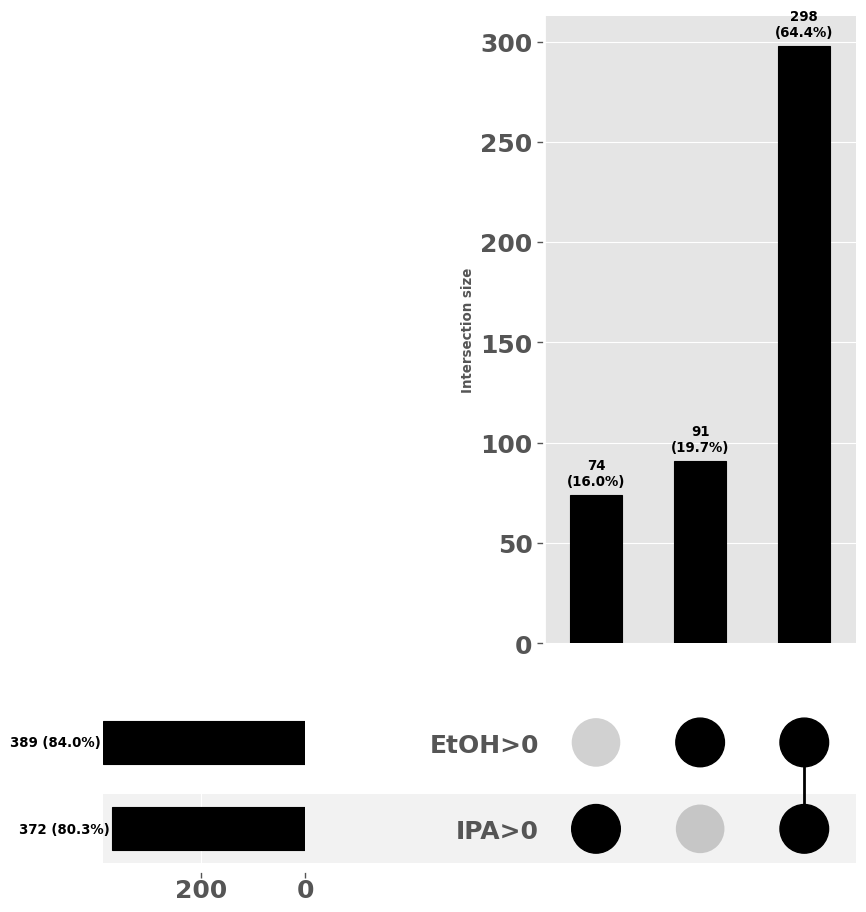

order


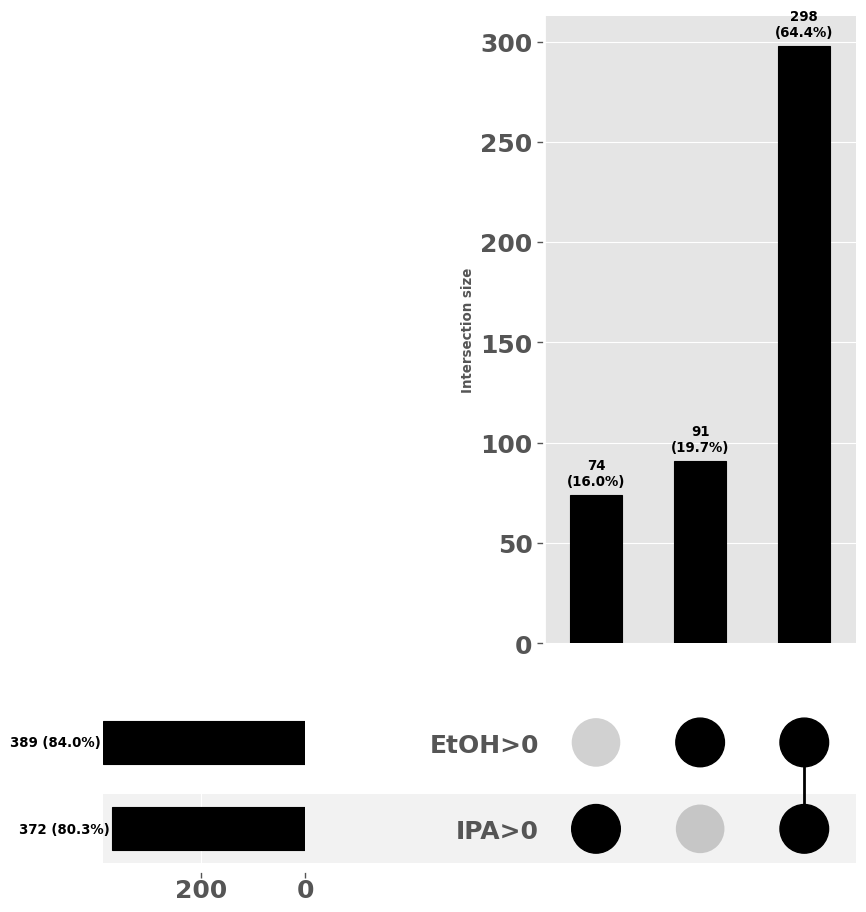

family


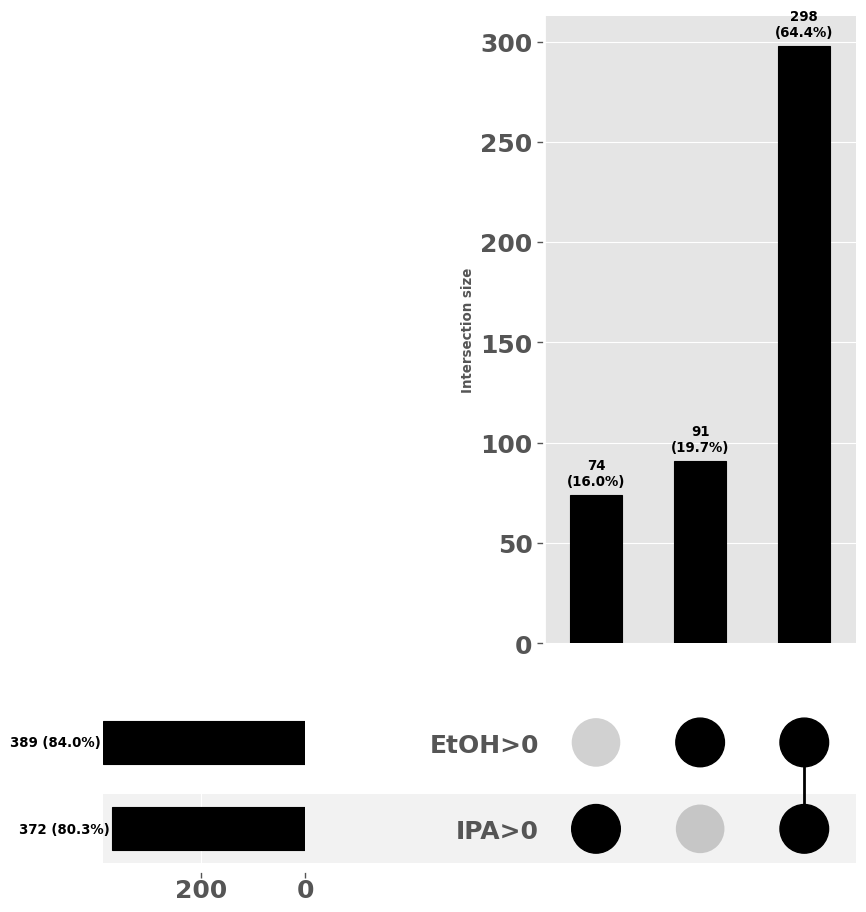

genus


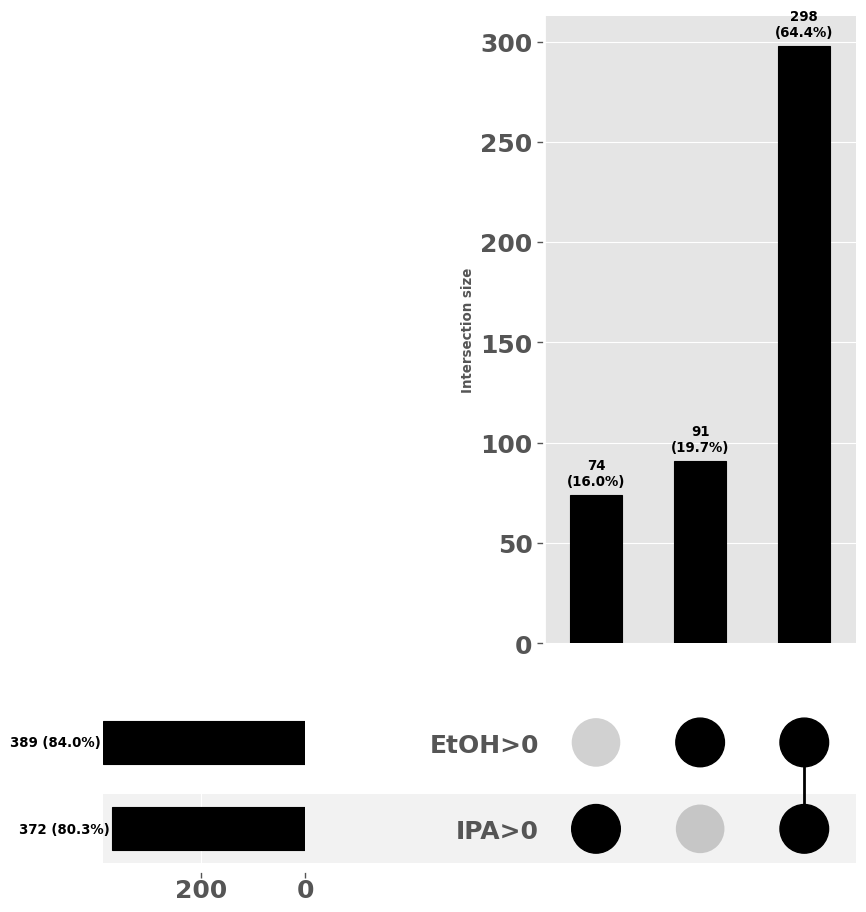

species


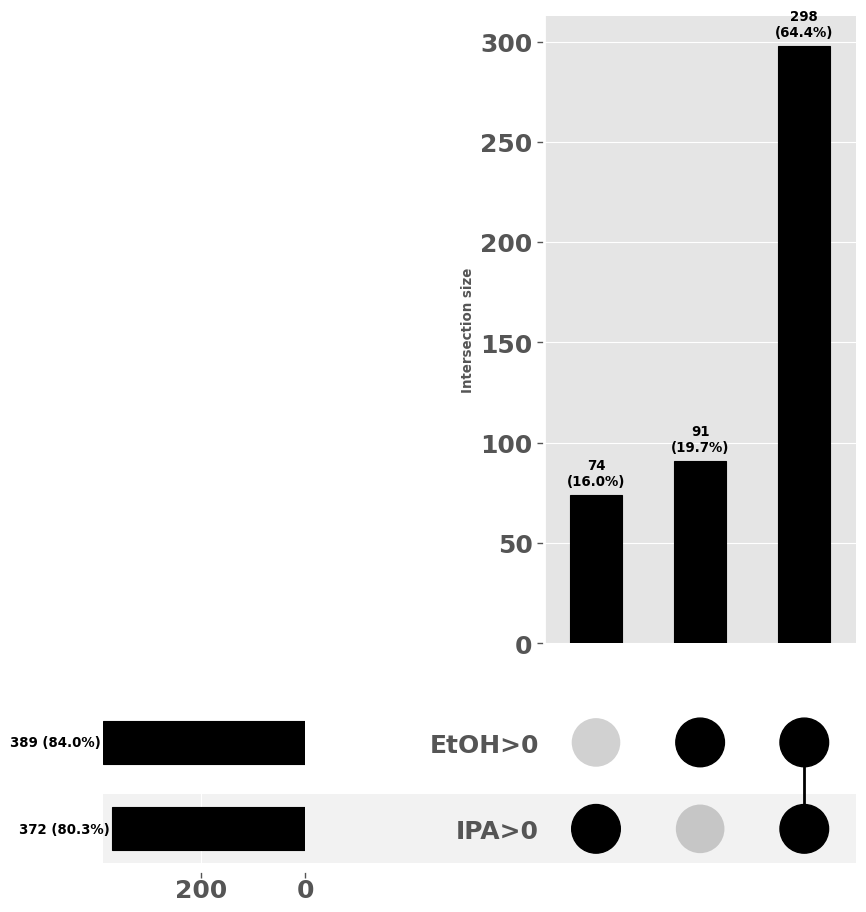

class


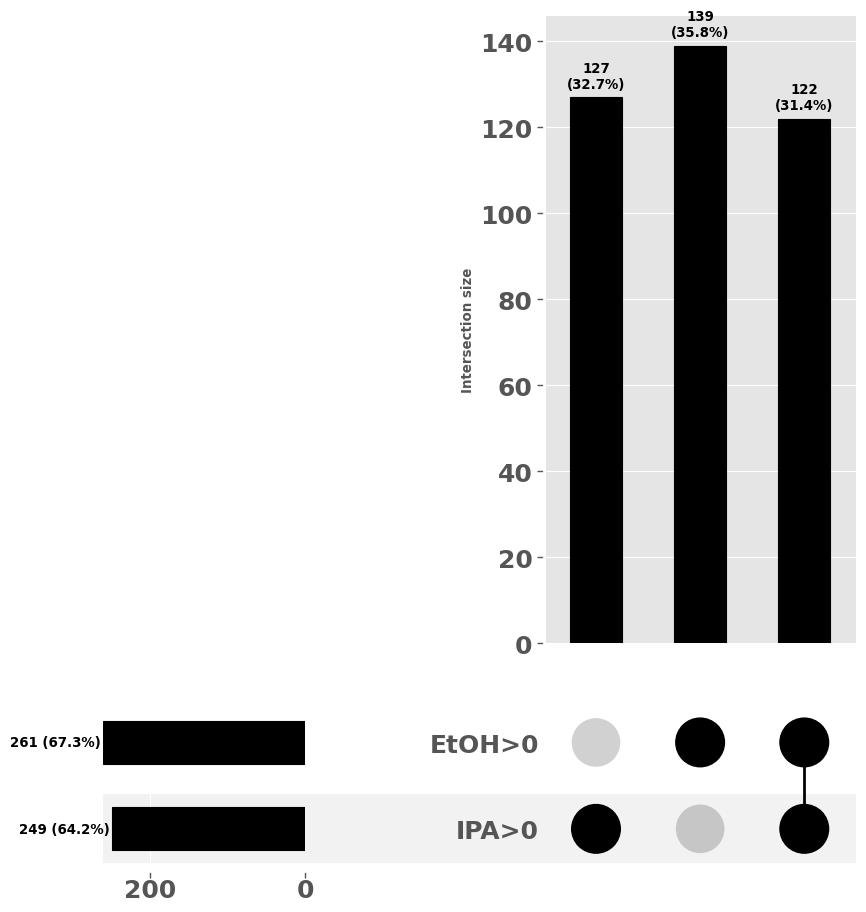

order


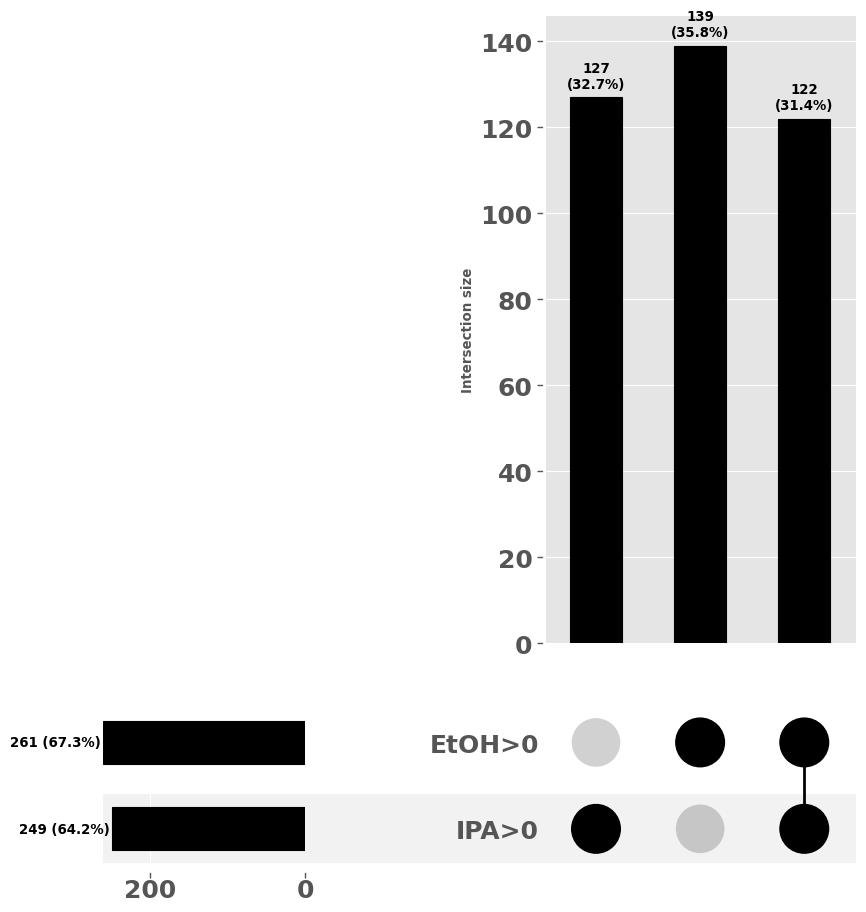

family


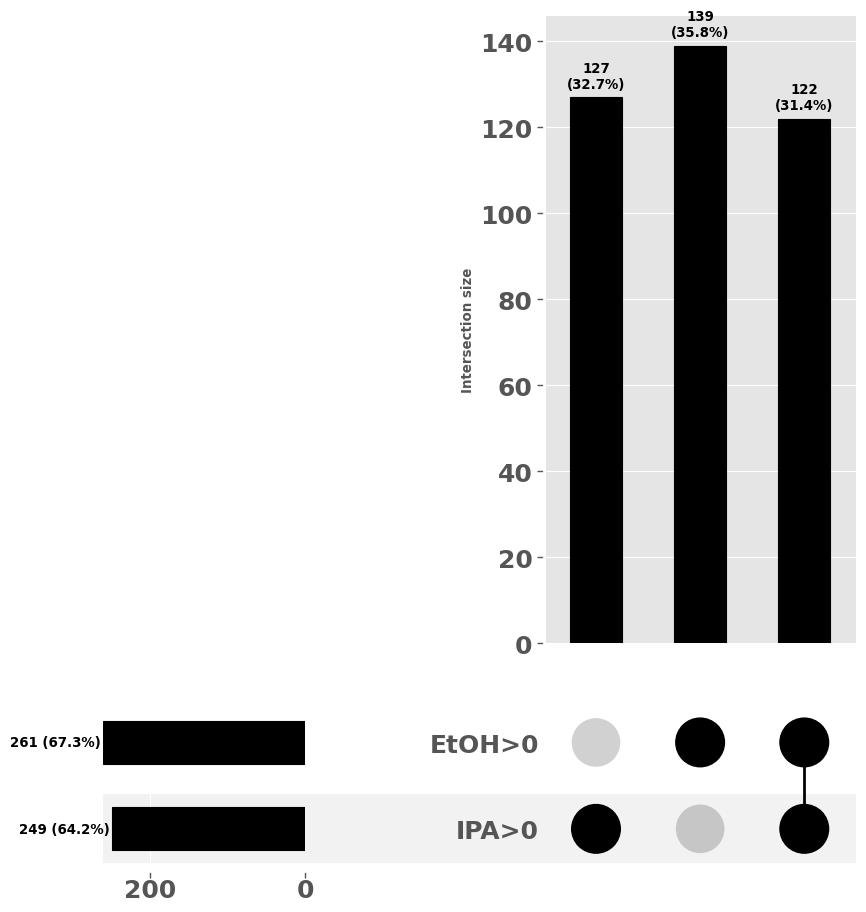

genus


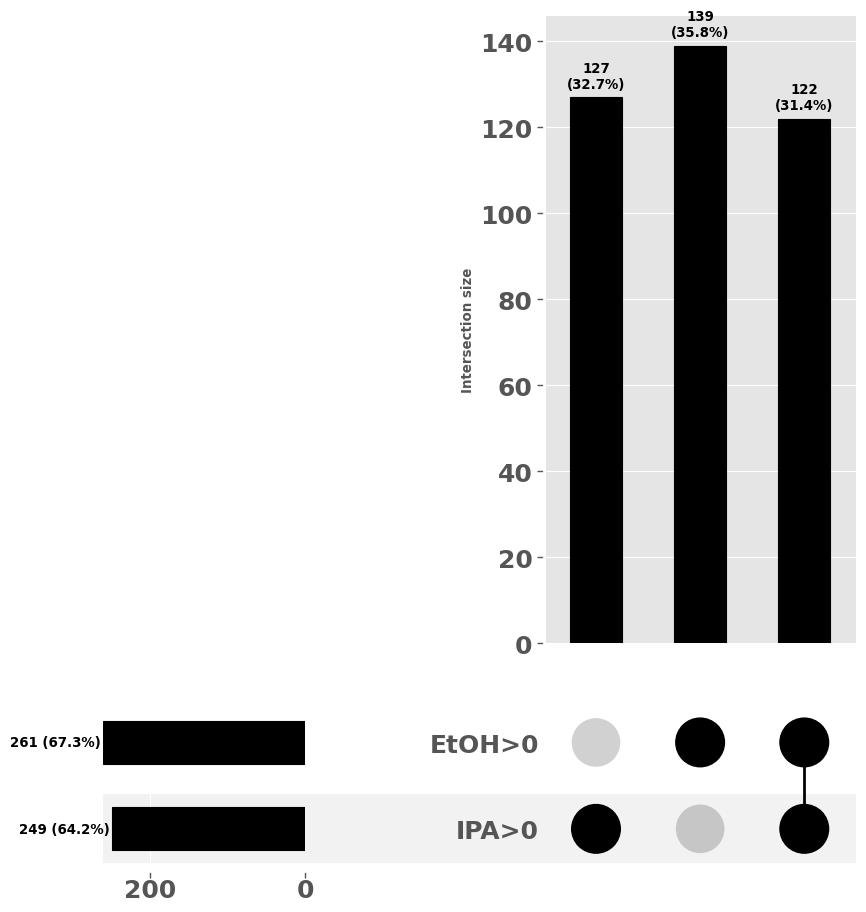

species


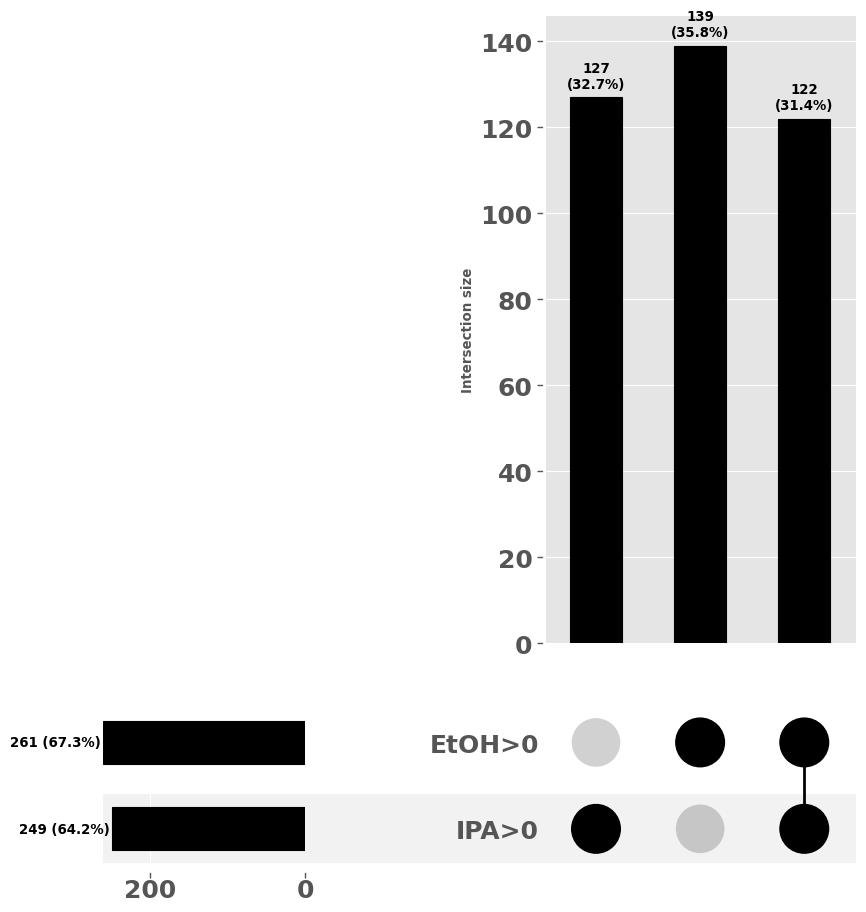

class


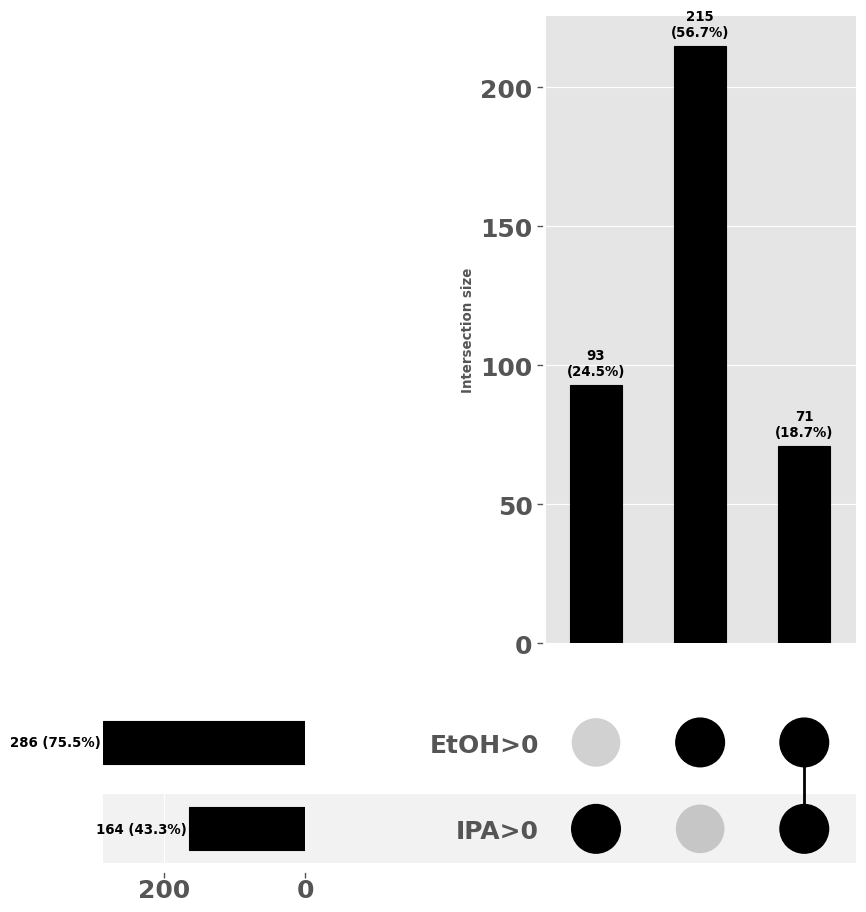

order


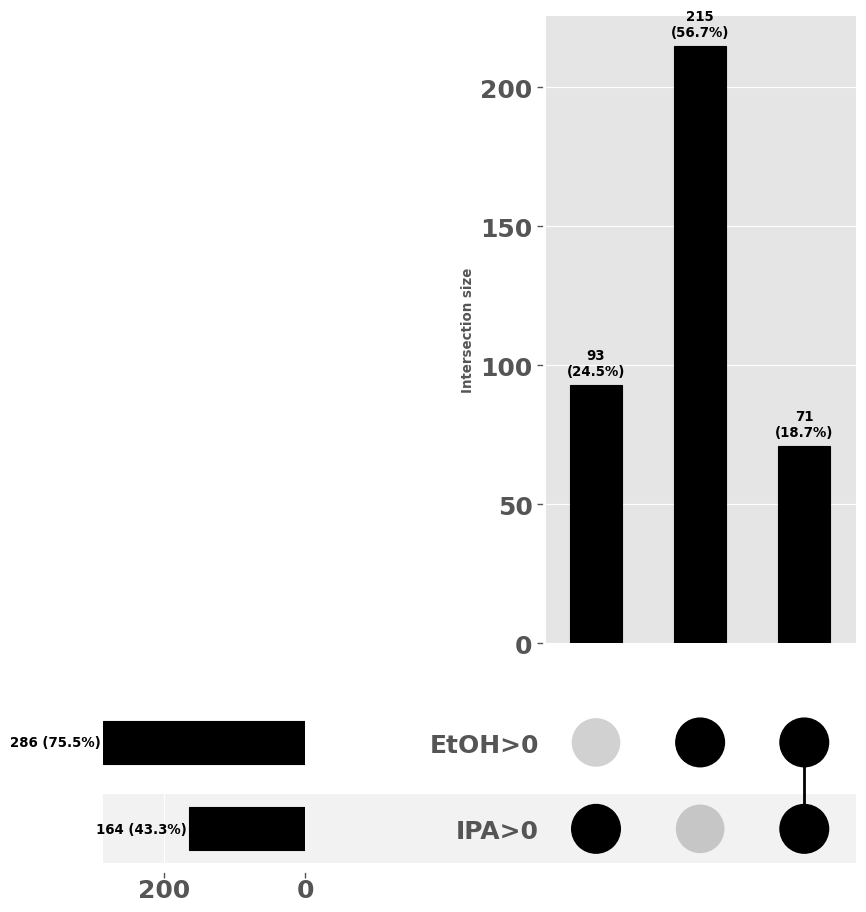

family


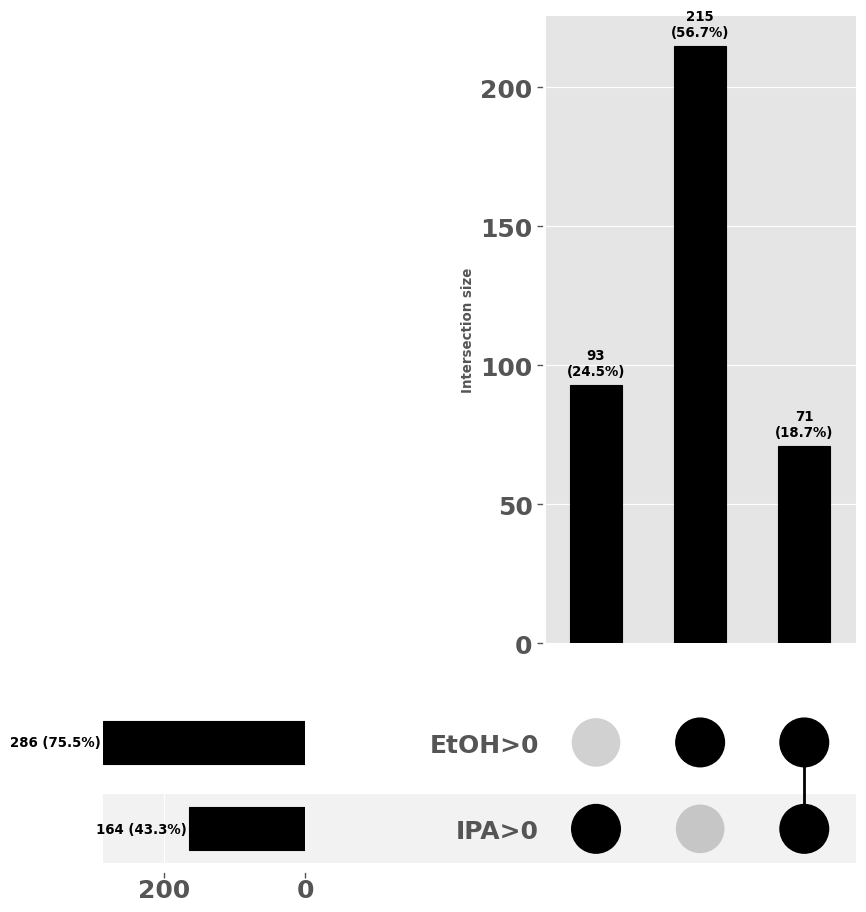

genus


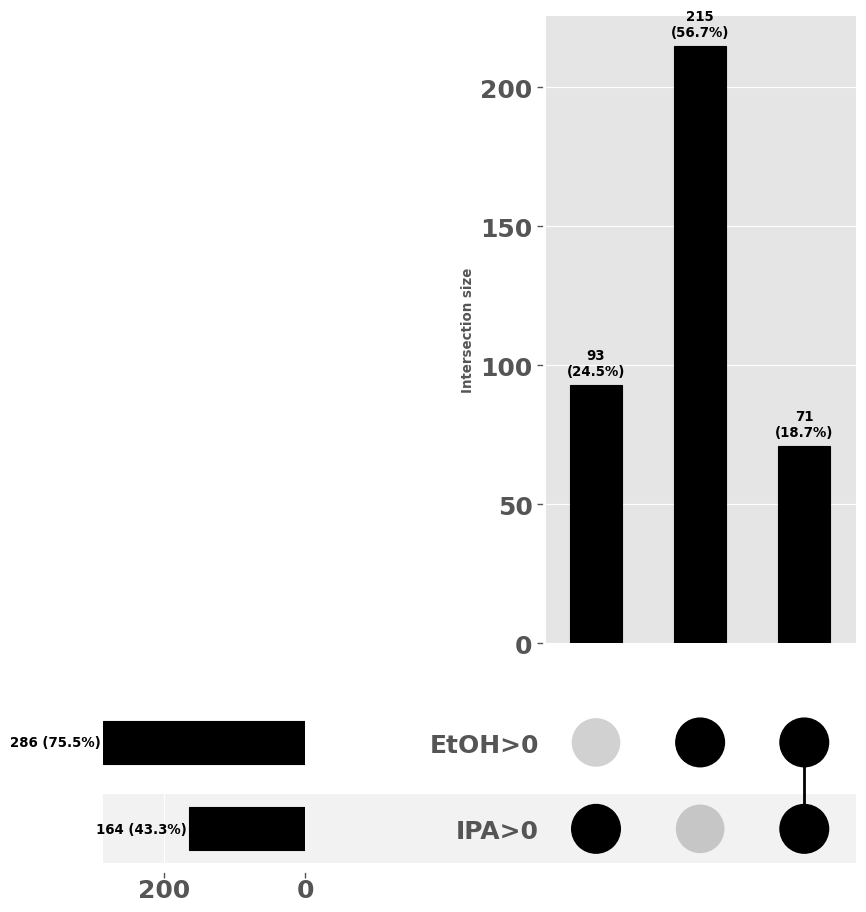

species


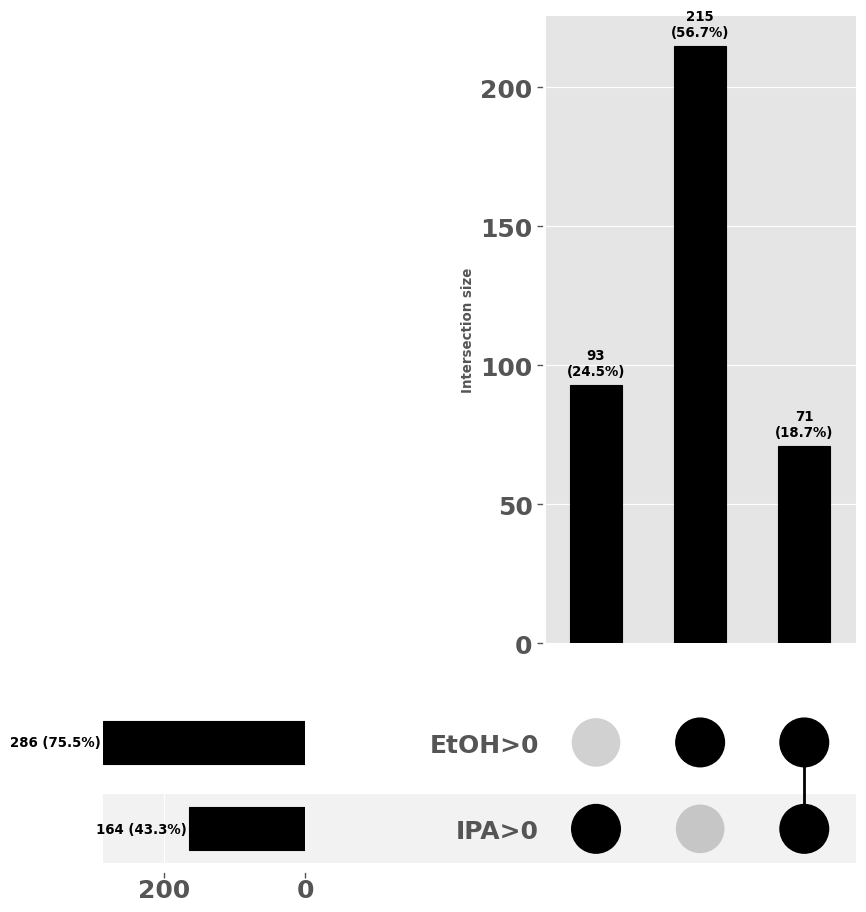

In [8]:
# Define different protocols
protocols = {}
protocols['hbm_feces_human'] = ['/matrix/data/lcms/matrix_lcms_hbm_biom_qiita_ids_noSingletons_st2_stool_human.qza',
                    '/matrix/metadata_samples/metadata_samples_qiita_20250326b.txt',
                    '/matrix/data/lcms/matrix_lcms_merged_biom_qiita_ids_taxonomy.qza']
protocols['hbm_feces_mouse'] = ['/matrix/data/lcms/matrix_lcms_hbm_biom_qiita_ids_noSingletons_st2_stool_mouse.qza',
                    '/matrix/metadata_samples/metadata_samples_qiita_20250326b.txt',
                    '/matrix/data/lcms/matrix_lcms_merged_biom_qiita_ids_taxonomy.qza']
protocols['hbm_saliva_before'] = ['/matrix/data/lcms/matrix_lcms_hbm_biom_qiita_ids_noSingletons_st2_saliva_before.qza',
                    '/matrix/metadata_samples/metadata_samples_qiita_20250326b.txt',
                    '/matrix/data/lcms/matrix_lcms_merged_biom_qiita_ids_taxonomy.qza']
protocols['hbm_saliva_after'] = ['/matrix/data/lcms/matrix_lcms_hbm_biom_qiita_ids_noSingletons_st2_saliva_after.qza',
                    '/matrix/metadata_samples/metadata_samples_qiita_20250326b.txt',
                    '/matrix/data/lcms/matrix_lcms_merged_biom_qiita_ids_taxonomy.qza']
protocols['lbm_skin_armpit'] = ['/matrix/data/lcms/matrix_lcms_lbm_biom_qiita_ids_noSingletons_st2_skin_armpit.qza',
                    '/matrix/metadata_samples/metadata_samples_qiita_20250326b.txt',
                    '/matrix/data/lcms/matrix_lcms_merged_biom_qiita_ids_taxonomy.qza']
protocols['lbm_skin_hand'] = ['/matrix/data/lcms/matrix_lcms_lbm_biom_qiita_ids_noSingletons_st2_skin_hand.qza',
                    '/matrix/metadata_samples/metadata_samples_qiita_20250326b.txt',
                    '/matrix/data/lcms/matrix_lcms_merged_biom_qiita_ids_taxonomy.qza']
protocols['lbm_surface_floor'] = ['/matrix/data/lcms/matrix_lcms_lbm_biom_qiita_ids_noSingletons_st2_surface_floor.qza',
                    '/matrix/metadata_samples/metadata_samples_qiita_20250326b.txt',
                    '/matrix/data/lcms/matrix_lcms_merged_biom_qiita_ids_taxonomy.qza']
protocols['lbm_surface_keyboard'] = ['/matrix/data/lcms/matrix_lcms_lbm_biom_qiita_ids_noSingletons_st2_surface_keyboard.qza',
                    '/matrix/metadata_samples/metadata_samples_qiita_20250326b.txt',
                    '/matrix/data/lcms/matrix_lcms_merged_biom_qiita_ids_taxonomy.qza']

# Repeat for all sample types
for protocol, (table, metadata, taxonomy) in protocols.items():
    # Import data
    table = q2.Artifact.load(table).view(biom.Table)
    metadata = q2.Metadata.load(metadata).to_dataframe()
    # Match tables
    shared_ = set(table.ids()) & set(metadata.index)
    table = table.filter(shared_)
    metadata = metadata.reindex(shared_)

    if 'qza' not in taxonomy:
        taxonomy = q2.Metadata.load(taxonomy).to_dataframe()
    else:
        taxonomy = q2.Artifact.load(taxonomy).view(q2.Metadata).to_dataframe()
    taxonomy = add_taxsplit(taxonomy) # Split by taxonomic level
    taxonomy.reindex(table.ids('observation'))

    total_kits = []
    for kit_, mfdf in metadata.groupby('storage_solution'):
        # Get all taxa for this level
        psbt = table.copy()
        psbt = psbt.filter(mfdf.index)
        keep_ = psbt.ids('observation')[psbt.sum('observation') > 0]
        psbt = psbt.filter(keep_, axis='observation')
        psbt = pd.DataFrame(psbt.sum(axis='observation'),
                            psbt.ids('observation'),
                            [kit_])
        total_kits.append(psbt)
    # Combine totals
    totaldf = pd.concat(total_kits, axis=1).fillna(0)
    totaldf.head(5)

    # Format plotting for each level
    formatted_levels = {}
    for level_ in taxonomy.columns[3:]:
        tax_ = taxonomy.loc[totaldf.index, level_].copy().dropna()
        totaldf_tax = totaldf.loc[tax_.index, :].copy()
        totaldf_tax[level_] = tax_.loc[totaldf_tax.index,]
        totaldf_tax = totaldf_tax.groupby(level_).sum()
        totaldf_tax = format_uplot(totaldf_tax)
        formatted_levels[level_] = totaldf_tax.copy()

    for level_, pltdf_ in formatted_levels.items():
        print(level_)
        # UpSet plot - Filters associations with < 5 unique taxa (min_subset_size)
        fig = plt.figure(figsize=(12,10))
        upset = UpSet(pltdf_, 
                      orientation = 'horizontal',
                      sort_by = 'degree',
                      sort_categories_by = '-input',
                      subset_size='count',
                      min_subset_size = 1,
                      max_subset_size = '100%',
                      element_size = 100,
                      show_counts=True,
                      show_percentages = True)
        upset.plot(fig=fig)
        # Save the figure to file
        plt.savefig('/matrix/results/upset_plots/lcms/protocol-%s_upset-%s.pdf' % (protocol, level_),dpi=600, 
                    bbox_inches='tight',
                    facecolor=fig.get_facecolor(), 
                    edgecolor='none')

        plt.show()
